In [1]:
%load_ext autoreload
%autoreload 2

Let's take a look at what happens when we have very unevenly scaled X and Y values.  

Here is the (uneven) moons dataset with Y * 1000 and X / 1000.

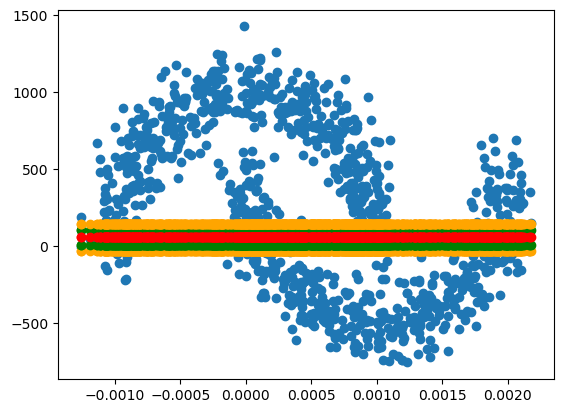

In [ ]:
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt

from skmdn import MixtureDensityEstimator
from sklearn.datasets import make_moons


n_samples = 1000
X_full, _ = make_moons(n_samples=n_samples, noise=0.1)
X = X_full[:, 0].reshape(-1, 1) / 1000 # Use only the first column as input
Y = X_full[:, 1].reshape(-1, 1)  # Predict the second column

# Add some noise to Y to make the problem more suitable for MDN
Y += 0.1 * np.random.randn(n_samples, 1)
Y = Y * 1000

mdn = MixtureDensityEstimator(epochs=1000)
mdn.fit(X, Y)

means, quantiles = mdn.predict(X, quantiles=[0.01, 0.1, 0.9, 0.99], resolution=10000)

plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')

We can see that MDN is unable to handle this case well. Let's use an sklearn pipeline and StandardScaler to scale X the data before fitting the model.

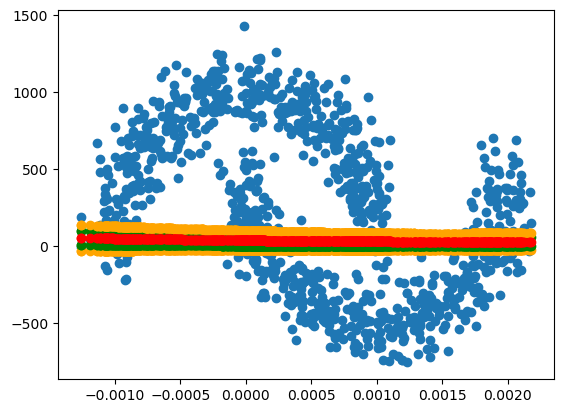

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

mdn_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('mdn', MixtureDensityEstimator(epochs=1000))
    ]
)

mdn_pipe.fit(X, Y)

means, quantiles = mdn_pipe.predict(X, quantiles=[0.01, 0.1, 0.9, 0.99], resolution=10000)

plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')

Maybe an improvement but still not great. Let's handle the y data now:

In [ ]:
from sklearn.compose import TransformedTargetRegressor

ttr_mdn = TransformedTargetRegressor(
    regressor=MixtureDensityEstimator(epochs=900),
    transformer=StandardScaler()
)

mdn_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('mdn', ttr_mdn),
    ]
)

mdn_pipe.fit(X, Y)

means, quantiles = mdn_pipe.predict(X, quantiles=[0.01, 0.1, 0.9, 0.99], resolution=10000)

plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')

IndexError: tuple index out of range

Here we run into some issue here with TransformTargetRegressor - it makes the data 1D and MDN takes 2D (N, 1) data.

At this point there are a couple of options:
1) Fix MDN at its source to handle 1D data (I tested this and it lead several other issues at fit-time).
2) Use pytorch to scale the data internally.
3) Use sklearn transformers to scale the data internally.
   
I went for option 3 here as sklearn is already installed and this package seems aimed at the sklearn user base. I have also made it in a way that is easy to pass other sklearn transformers, not just StandardScaler.

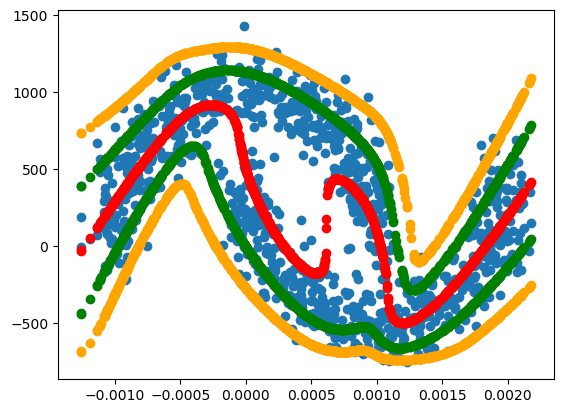

In [20]:
mdn_ss = MixtureDensityEstimator(epochs=1000, transformer=StandardScaler())

mdn_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('mdn', mdn_ss),
    ]
)

mdn_pipe.fit(X, Y)

means, quantiles = mdn_pipe.predict(X, quantiles=[0.01, 0.1, 0.9, 0.99], resolution=10000)

plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')

This gives much better results out of the box and handles the rescaling of the data back to its original form.  

Here is an example of passing MinMaxScaler instead of StandardScaler and it works seemlessly (and surprisingly gives nicer results in the plot).  

This is all good but our next issue is using our pipeline estimator to make full use fo the great extra features supplied by MDN.

In [21]:
mdn_pipe.pdf(X)

AttributeError: 'Pipeline' object has no attribute 'pdf'

We can use `mdn_pipe[-1]` to access the `.pdf` method of the MDN model.

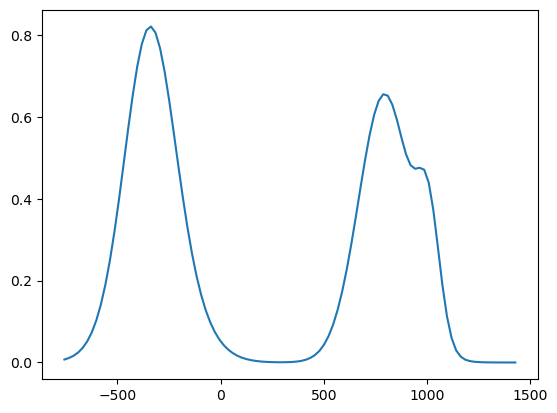

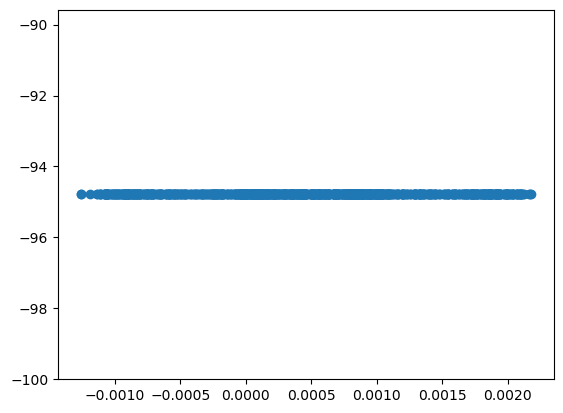

In [ ]:
# looks believable but is not scaled correctly.
pdf, ys = mdn_pipe[-1].pdf(X)
plt.plot(ys, pdf[0])
plt.show()

# this clearly needs transforming first.
y_pred = mdn_pipe[-1].predict(X)
plt.scatter(X, y_pred)

However, the `X` data still needs to be scaled for any predictions. This is not ideal as it is very un-user friendly.  

Here is a potential solution using a custom MDNPipeline class that inherits from `Pipeline`.

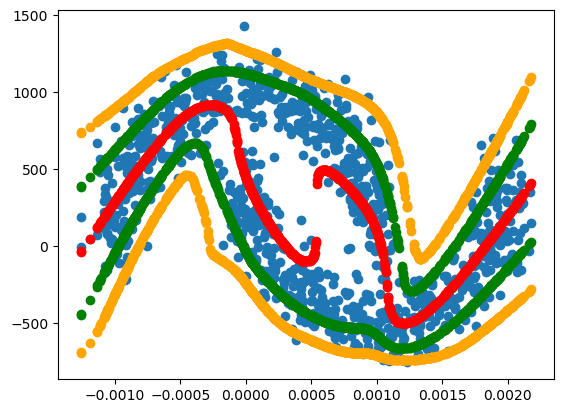

In [ ]:
from skmdn.pipeline import MDNPipeline


mdn_pipe = MDNPipeline(
    [
        ('scaler', StandardScaler()),
        ('mdn', MixtureDensityEstimator(epochs=1000, transformer=StandardScaler())),
    ]
)

mdn_pipe.fit(X, Y)

means, quantiles = mdn_pipe.predict(X, quantiles=[0.01, 0.1, 0.9, 0.99], resolution=10000)

plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')


And with some small changes to Vincent's awesome interactive plot, we can recover all of the original functionality of the MDN model.

In [77]:
x_range = X.max() - X.min()
n = 10000
interact_step = x_range / n

@interact(x=(X.min(), X.max(), interact_step))
def f(x):
    pdf, ys = mdn_pipe.pdf(np.array([x]).reshape(1, -1))
    cdf = pdf.cumsum() / pdf.cumsum().max()
    
    bestmean = ys[np.argmax(cdf > 0.5)]
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.scatter(X, Y)
    plt.vlines(ymin=-1, ymax=1.5, x=x, color='orange', alpha=0.5)
    plt.scatter([x], [bestmean])
    plt.plot((pdf[0] / pdf[0].max() * x_range) + x, ys, color='orange')
    plt.title("interaction")

    plt.subplot(132)
    plt.plot(ys, pdf[0])
    plt.title("pdf")

    plt.subplot(133)
    plt.plot(ys, cdf)
    plt.scatter(ys[np.argmax(cdf > 0.5)], [0.5], color="orange")
    plt.title("cdf")

interactive(children=(FloatSlider(value=0.00045987173208765996, description='x', max=0.0021819626784597974, mi…